# Importing

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [16]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    sigma = ds.sigma_theta
    cell = ds.e3t
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, sigma, cell, date, mask)


# Masking

In [17]:
def masking (depth, temp, saline, sigma, cell, mask):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)
    sigma = sigma.where(mask[0,depth]==1)
    cell = cell.where(mask[0,depth]==1)

    return (temp, saline, sigma, cell)


# SOM

In [18]:
def som (depth, temp, saline, sigma, cell):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten(), sigma[0,depth].values.flatten(), cell[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2]) & ~np.isnan(inputs[3])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [19]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [20]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,                    
                    )
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.set_title('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('SOM clustering using temperature, salinity and sigma-t for ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 5176 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 10.86 degrees Celsius
The mean temperature for cluster 0 is 9.1 degrees Celsius 

The minimum salinity for cluster 0 is 20.52 g/kg
The maximum salinity for cluster 0 is 23.77 g/kg
The mean salinity for cluster 0 is 22.27 g/kg 


The amount of grid boxes for cluster 1 is 15061 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.84 degrees Celsius 

The minimum salinity for cluster 1 is 26.05 g/kg
The maximum salinity for cluster 1 is 27.95 g/kg
The mean salinity for cluster 1 is 26.98 g/kg 


The amount of grid boxes for cluster 2 is 27216 

The minimum temperature for cluster 2 is 6.81 degrees Celsius
The maximum temperature for cluster 2 is 9.73 degrees Celsius
The mean temperature for cluster 2 is 8.01 degrees Celsius 

T

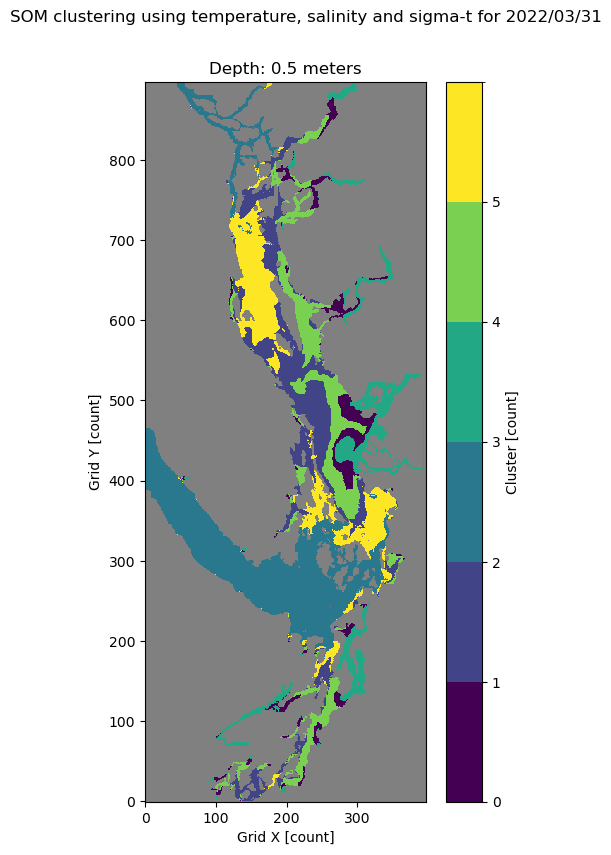

The amount of grid boxes for cluster 0 is 6383 

The minimum temperature for cluster 0 is 7.26 degrees Celsius
The maximum temperature for cluster 0 is 10.54 degrees Celsius
The mean temperature for cluster 0 is 9.15 degrees Celsius 

The minimum salinity for cluster 0 is 22.53 g/kg
The maximum salinity for cluster 0 is 25.12 g/kg
The mean salinity for cluster 0 is 24.03 g/kg 


The amount of grid boxes for cluster 1 is 11432 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.0 degrees Celsius
The mean temperature for cluster 1 is 8.68 degrees Celsius 

The minimum salinity for cluster 1 is 26.62 g/kg
The maximum salinity for cluster 1 is 28.19 g/kg
The mean salinity for cluster 1 is 27.43 g/kg 


The amount of grid boxes for cluster 2 is 27486 

The minimum temperature for cluster 2 is 6.72 degrees Celsius
The maximum temperature for cluster 2 is 9.72 degrees Celsius
The mean temperature for cluster 2 is 8.0 degrees Celsius 

Th

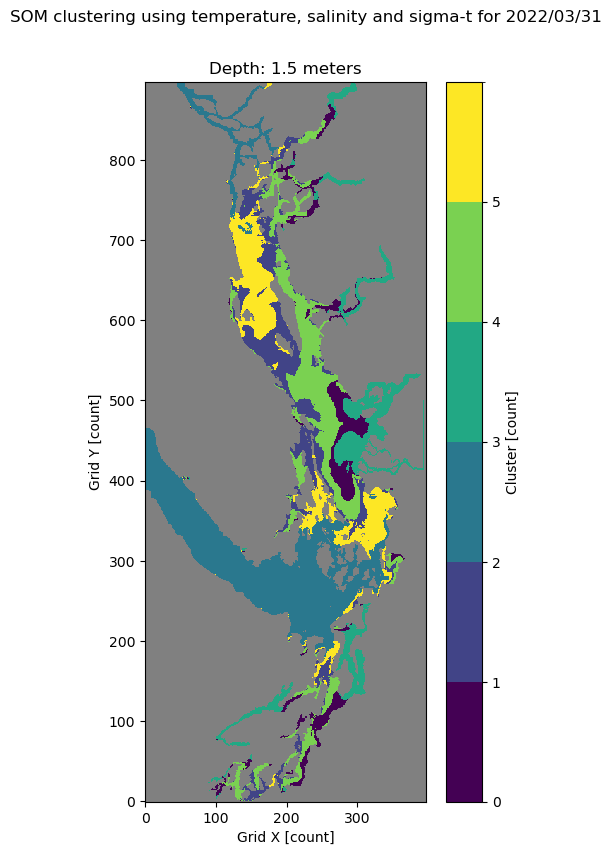

The amount of grid boxes for cluster 0 is 9159 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.12 degrees Celsius
The mean temperature for cluster 0 is 9.05 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 23.81 g/kg
The mean salinity for cluster 0 is 19.08 g/kg 


The amount of grid boxes for cluster 1 is 14730 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 10.3 degrees Celsius
The mean temperature for cluster 1 is 8.79 degrees Celsius 

The minimum salinity for cluster 1 is 25.59 g/kg
The maximum salinity for cluster 1 is 27.28 g/kg
The mean salinity for cluster 1 is 26.55 g/kg 


The amount of grid boxes for cluster 2 is 9177 

The minimum temperature for cluster 2 is 7.11 degrees Celsius
The maximum temperature for cluster 2 is 9.68 degrees Celsius
The mean temperature for cluster 2 is 8.37 degrees Celsius 

The 

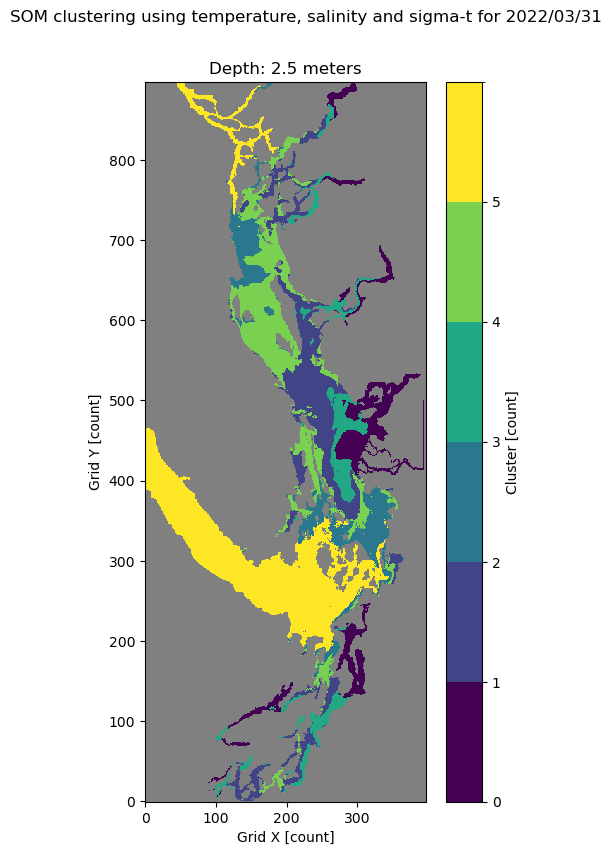

The amount of grid boxes for cluster 0 is 9897 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 9.63 degrees Celsius
The mean temperature for cluster 0 is 8.36 degrees Celsius 

The minimum salinity for cluster 0 is 28.24 g/kg
The maximum salinity for cluster 0 is 29.25 g/kg
The mean salinity for cluster 0 is 28.7 g/kg 


The amount of grid boxes for cluster 1 is 14848 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 10.28 degrees Celsius
The mean temperature for cluster 1 is 8.62 degrees Celsius 

The minimum salinity for cluster 1 is 26.09 g/kg
The maximum salinity for cluster 1 is 27.5 g/kg
The mean salinity for cluster 1 is 26.86 g/kg 


The amount of grid boxes for cluster 2 is 8052 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.84 degrees Celsius
The mean temperature for cluster 2 is 8.82 degrees Celsius 

The

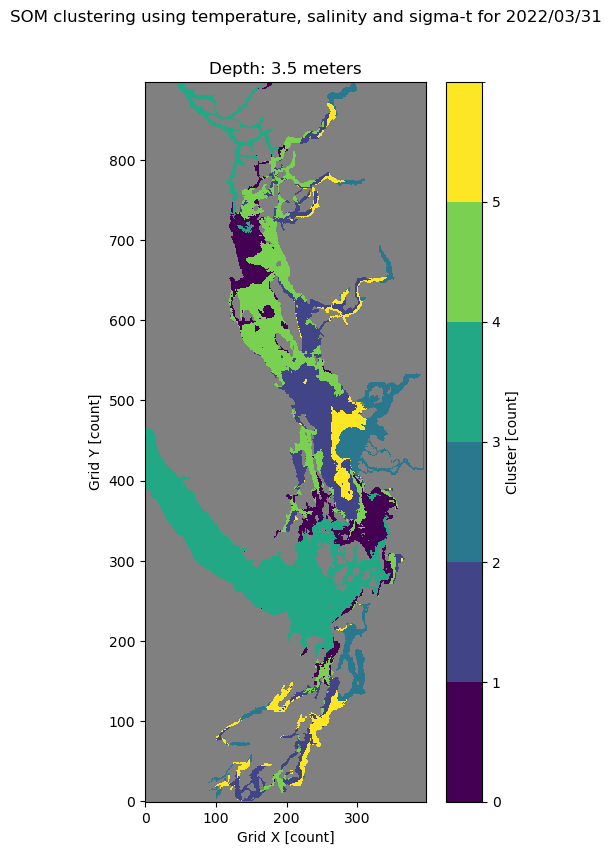

The amount of grid boxes for cluster 0 is 6743 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.53 degrees Celsius
The mean temperature for cluster 0 is 8.67 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 25.84 g/kg
The mean salinity for cluster 0 is 21.79 g/kg 


The amount of grid boxes for cluster 1 is 16095 

The minimum temperature for cluster 1 is 7.32 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 8.33 degrees Celsius 

The minimum salinity for cluster 1 is 26.88 g/kg
The maximum salinity for cluster 1 is 28.03 g/kg
The mean salinity for cluster 1 is 27.53 g/kg 


The amount of grid boxes for cluster 2 is 7477 

The minimum temperature for cluster 2 is 6.87 degrees Celsius
The maximum temperature for cluster 2 is 9.31 degrees Celsius
The mean temperature for cluster 2 is 8.23 degrees Celsius 

The

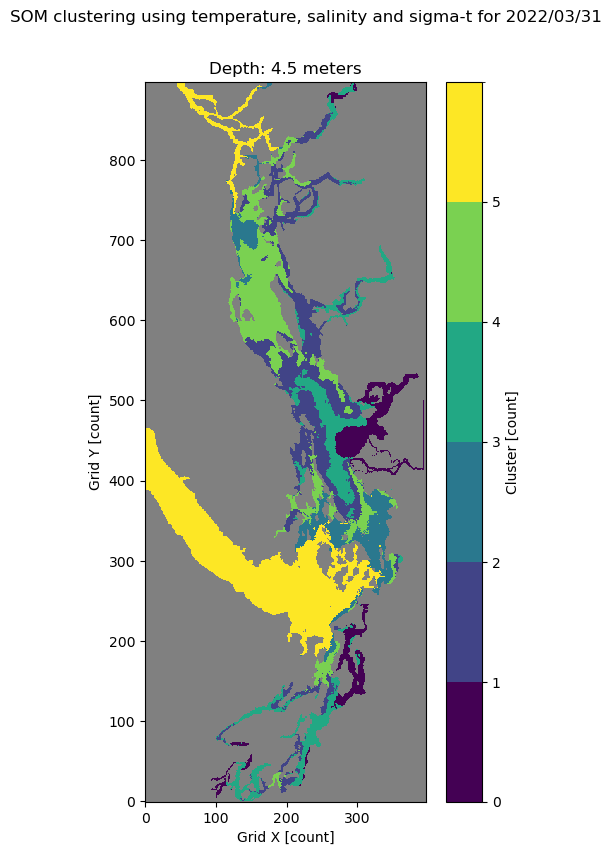

The amount of grid boxes for cluster 0 is 15202 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.37 degrees Celsius
The mean temperature for cluster 0 is 8.48 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.43 g/kg
The mean salinity for cluster 0 is 25.44 g/kg 


The amount of grid boxes for cluster 1 is 17751 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.17 degrees Celsius 

The minimum salinity for cluster 1 is 27.68 g/kg
The maximum salinity for cluster 1 is 28.67 g/kg
The mean salinity for cluster 1 is 28.24 g/kg 


The amount of grid boxes for cluster 2 is 6130 

The minimum temperature for cluster 2 is 6.54 degrees Celsius
The maximum temperature for cluster 2 is 9.24 degrees Celsius
The mean temperature for cluster 2 is 8.1 degrees Celsius 

The 

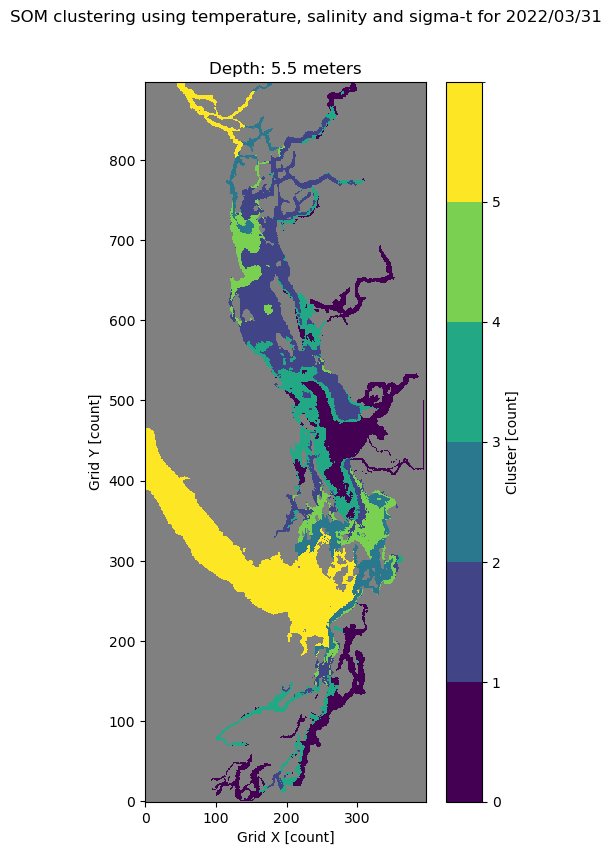

The amount of grid boxes for cluster 0 is 22095 

The minimum temperature for cluster 0 is 6.68 degrees Celsius
The maximum temperature for cluster 0 is 9.02 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 29.62 g/kg
The maximum salinity for cluster 0 is 31.42 g/kg
The mean salinity for cluster 0 is 30.6 g/kg 


The amount of grid boxes for cluster 1 is 10785 

The minimum temperature for cluster 1 is 7.84 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.31 degrees Celsius 

The minimum salinity for cluster 1 is 28.15 g/kg
The maximum salinity for cluster 1 is 29.09 g/kg
The mean salinity for cluster 1 is 28.66 g/kg 


The amount of grid boxes for cluster 2 is 8957 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 9.81 degrees Celsius
The mean temperature for cluster 2 is 8.51 degrees Celsius 

The

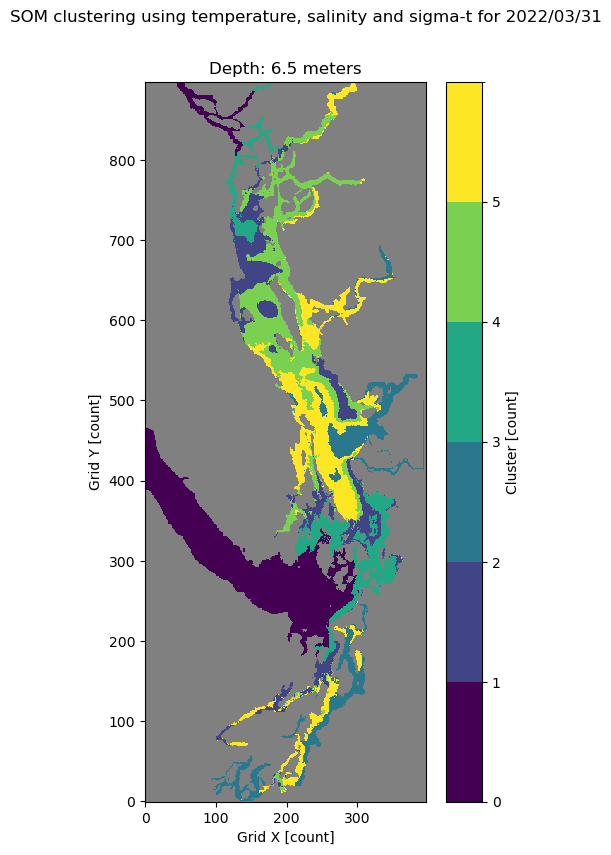

The amount of grid boxes for cluster 0 is 21622 

The minimum temperature for cluster 0 is 6.68 degrees Celsius
The maximum temperature for cluster 0 is 8.76 degrees Celsius
The mean temperature for cluster 0 is 7.9 degrees Celsius 

The minimum salinity for cluster 0 is 29.66 g/kg
The maximum salinity for cluster 0 is 31.44 g/kg
The mean salinity for cluster 0 is 30.63 g/kg 


The amount of grid boxes for cluster 1 is 6792 

The minimum temperature for cluster 1 is 7.75 degrees Celsius
The maximum temperature for cluster 1 is 8.95 degrees Celsius
The mean temperature for cluster 1 is 8.2 degrees Celsius 

The minimum salinity for cluster 1 is 28.79 g/kg
The maximum salinity for cluster 1 is 29.38 g/kg
The mean salinity for cluster 1 is 29.03 g/kg 


The amount of grid boxes for cluster 2 is 10888 

The minimum temperature for cluster 2 is 7.42 degrees Celsius
The maximum temperature for cluster 2 is 10.3 degrees Celsius
The mean temperature for cluster 2 is 8.29 degrees Celsius 

The 

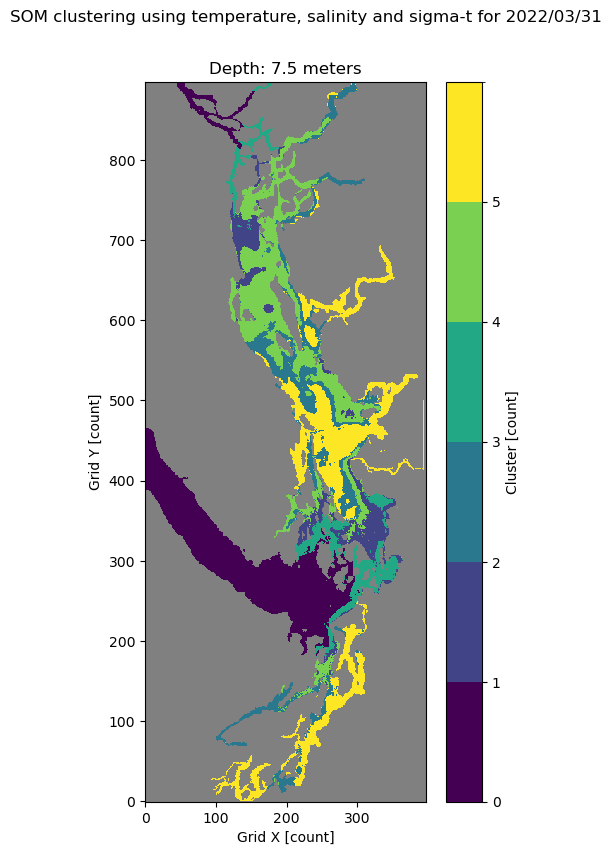

The amount of grid boxes for cluster 0 is 21550 

The minimum temperature for cluster 0 is 6.68 degrees Celsius
The maximum temperature for cluster 0 is 8.75 degrees Celsius
The mean temperature for cluster 0 is 7.89 degrees Celsius 

The minimum salinity for cluster 0 is 29.67 g/kg
The maximum salinity for cluster 0 is 31.46 g/kg
The mean salinity for cluster 0 is 30.64 g/kg 


The amount of grid boxes for cluster 1 is 7174 

The minimum temperature for cluster 1 is 7.7 degrees Celsius
The maximum temperature for cluster 1 is 8.98 degrees Celsius
The mean temperature for cluster 1 is 8.17 degrees Celsius 

The minimum salinity for cluster 1 is 28.78 g/kg
The maximum salinity for cluster 1 is 29.35 g/kg
The mean salinity for cluster 1 is 29.01 g/kg 


The amount of grid boxes for cluster 2 is 1627 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 9.68 degrees Celsius
The mean temperature for cluster 2 is 8.31 degrees Celsius 

The 

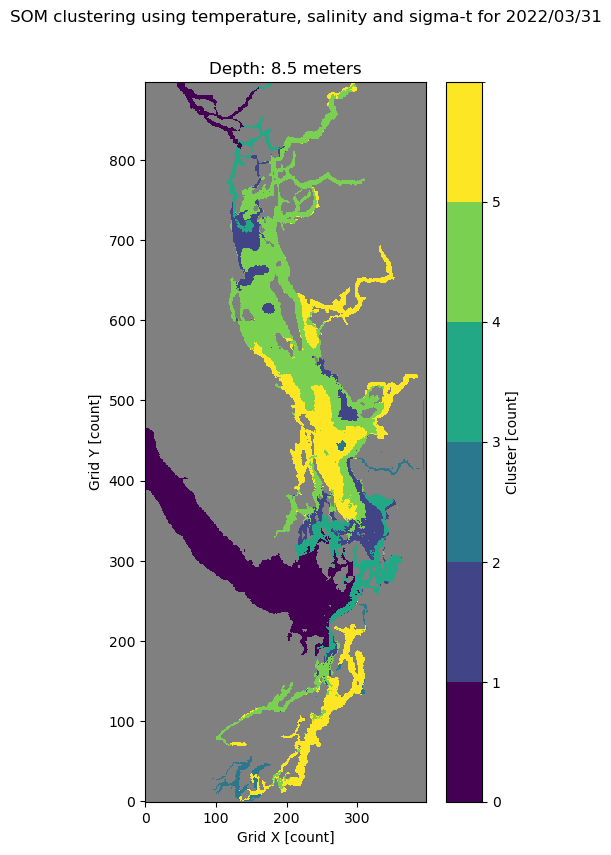

The amount of grid boxes for cluster 0 is 19501 

The minimum temperature for cluster 0 is 7.39 degrees Celsius
The maximum temperature for cluster 0 is 8.49 degrees Celsius
The mean temperature for cluster 0 is 7.92 degrees Celsius 

The minimum salinity for cluster 0 is 27.69 g/kg
The maximum salinity for cluster 0 is 28.72 g/kg
The mean salinity for cluster 0 is 28.45 g/kg 


The amount of grid boxes for cluster 1 is 11241 

The minimum temperature for cluster 1 is 7.63 degrees Celsius
The maximum temperature for cluster 1 is 9.37 degrees Celsius
The mean temperature for cluster 1 is 8.14 degrees Celsius 

The minimum salinity for cluster 1 is 28.68 g/kg
The maximum salinity for cluster 1 is 29.14 g/kg
The mean salinity for cluster 1 is 28.9 g/kg 


The amount of grid boxes for cluster 2 is 6292 

The minimum temperature for cluster 2 is 6.16 degrees Celsius
The maximum temperature for cluster 2 is 8.63 degrees Celsius
The mean temperature for cluster 2 is 7.9 degrees Celsius 

The 

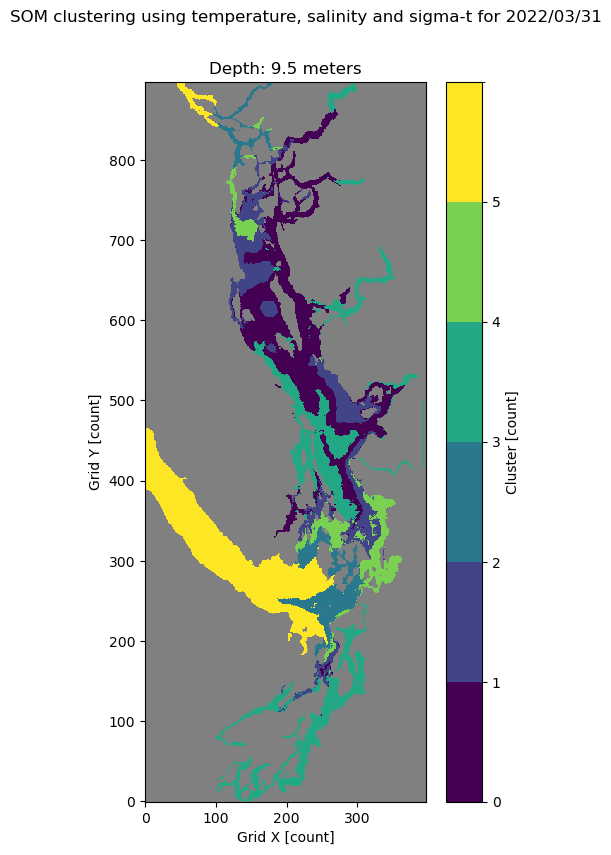

The amount of grid boxes for cluster 0 is 19471 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.87 degrees Celsius 

The minimum salinity for cluster 0 is 29.94 g/kg
The maximum salinity for cluster 0 is 31.56 g/kg
The mean salinity for cluster 0 is 30.74 g/kg 


The amount of grid boxes for cluster 1 is 5814 

The minimum temperature for cluster 1 is 7.62 degrees Celsius
The maximum temperature for cluster 1 is 8.77 degrees Celsius
The mean temperature for cluster 1 is 8.12 degrees Celsius 

The minimum salinity for cluster 1 is 29.05 g/kg
The maximum salinity for cluster 1 is 29.54 g/kg
The mean salinity for cluster 1 is 29.26 g/kg 


The amount of grid boxes for cluster 2 is 13463 

The minimum temperature for cluster 2 is 6.38 degrees Celsius
The maximum temperature for cluster 2 is 10.34 degrees Celsius
The mean temperature for cluster 2 is 8.5 degrees Celsius 

Th

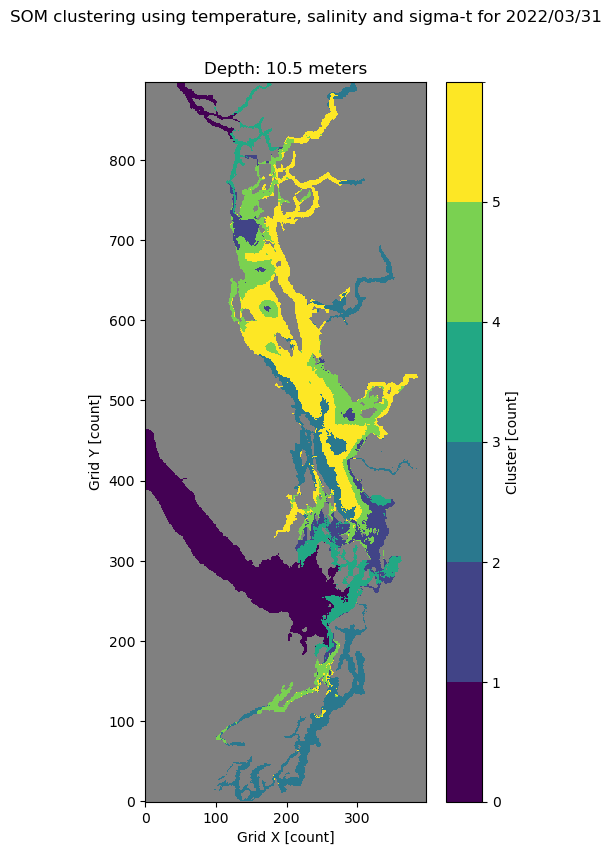

The amount of grid boxes for cluster 0 is 15576 

The minimum temperature for cluster 0 is 7.45 degrees Celsius
The maximum temperature for cluster 0 is 10.23 degrees Celsius
The mean temperature for cluster 0 is 8.1 degrees Celsius 

The minimum salinity for cluster 0 is 28.37 g/kg
The maximum salinity for cluster 0 is 29.25 g/kg
The mean salinity for cluster 0 is 28.6 g/kg 


The amount of grid boxes for cluster 1 is 5640 

The minimum temperature for cluster 1 is 7.54 degrees Celsius
The maximum temperature for cluster 1 is 8.62 degrees Celsius
The mean temperature for cluster 1 is 8.09 degrees Celsius 

The minimum salinity for cluster 1 is 29.13 g/kg
The maximum salinity for cluster 1 is 29.64 g/kg
The mean salinity for cluster 1 is 29.36 g/kg 


The amount of grid boxes for cluster 2 is 19276 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 8.33 degrees Celsius
The mean temperature for cluster 2 is 7.86 degrees Celsius 

The

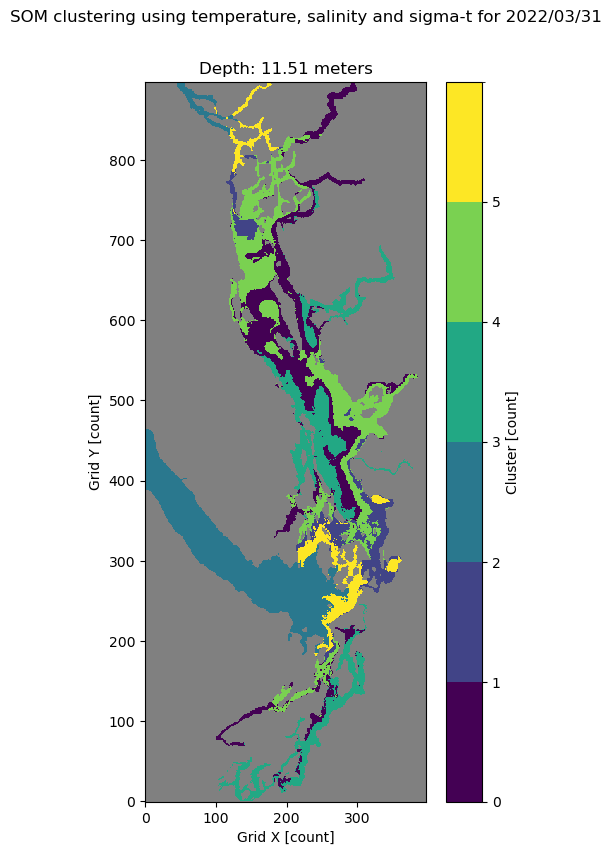

The amount of grid boxes for cluster 0 is 16266 

The minimum temperature for cluster 0 is 7.26 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.84 degrees Celsius 

The minimum salinity for cluster 0 is 30.31 g/kg
The maximum salinity for cluster 0 is 31.64 g/kg
The mean salinity for cluster 0 is 30.89 g/kg 


The amount of grid boxes for cluster 1 is 5192 

The minimum temperature for cluster 1 is 6.45 degrees Celsius
The maximum temperature for cluster 1 is 8.65 degrees Celsius
The mean temperature for cluster 1 is 7.95 degrees Celsius 

The minimum salinity for cluster 1 is 29.32 g/kg
The maximum salinity for cluster 1 is 29.88 g/kg
The mean salinity for cluster 1 is 29.59 g/kg 


The amount of grid boxes for cluster 2 is 23039 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 8.31 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 

Th

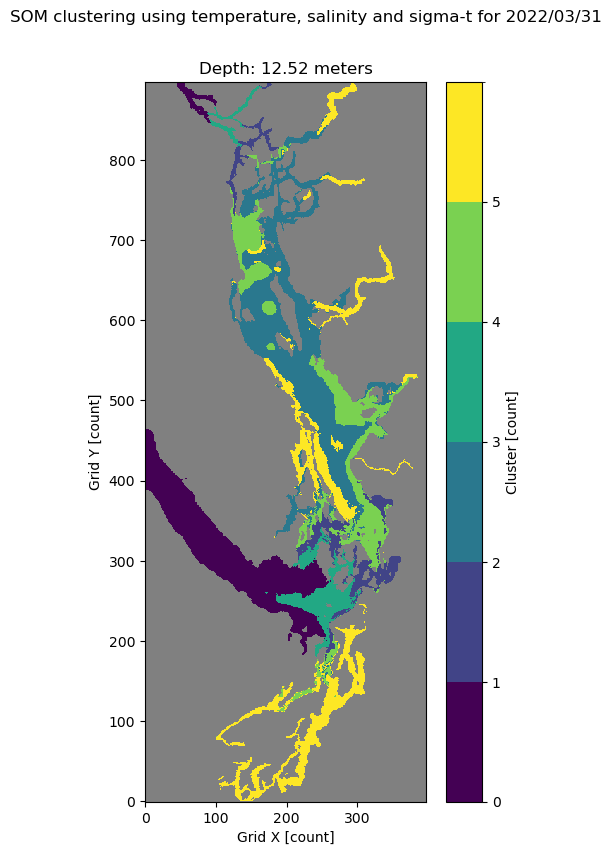

The amount of grid boxes for cluster 0 is 23510 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 8.36 degrees Celsius
The mean temperature for cluster 0 is 7.94 degrees Celsius 

The minimum salinity for cluster 0 is 27.98 g/kg
The maximum salinity for cluster 0 is 28.97 g/kg
The mean salinity for cluster 0 is 28.67 g/kg 


The amount of grid boxes for cluster 1 is 12143 

The minimum temperature for cluster 1 is 7.74 degrees Celsius
The maximum temperature for cluster 1 is 8.64 degrees Celsius
The mean temperature for cluster 1 is 8.14 degrees Celsius 

The minimum salinity for cluster 1 is 28.91 g/kg
The maximum salinity for cluster 1 is 29.31 g/kg
The mean salinity for cluster 1 is 29.1 g/kg 


The amount of grid boxes for cluster 2 is 5457 

The minimum temperature for cluster 2 is 6.56 degrees Celsius
The maximum temperature for cluster 2 is 8.65 degrees Celsius
The mean temperature for cluster 2 is 7.88 degrees Celsius 

The

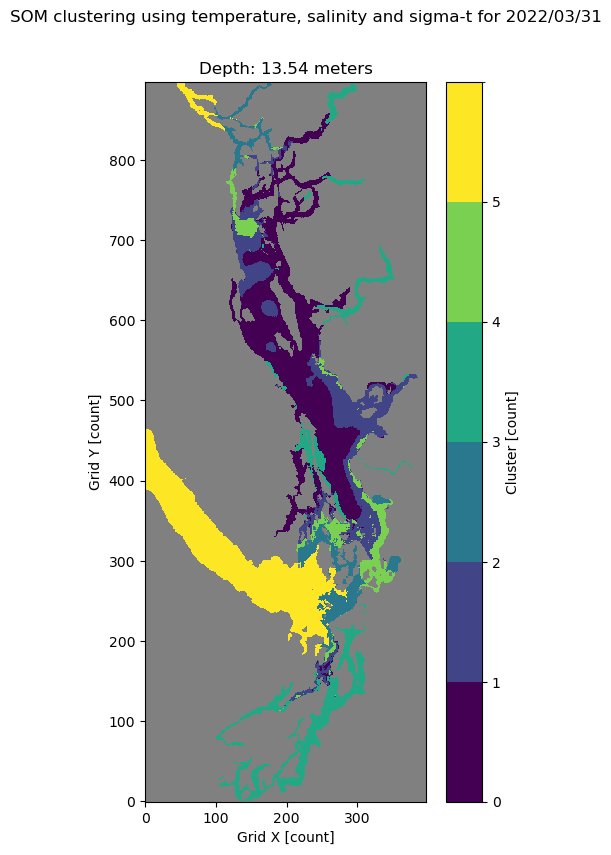

The amount of grid boxes for cluster 0 is 13500 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 10.54 degrees Celsius
The mean temperature for cluster 0 is 8.66 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.54 g/kg
The mean salinity for cluster 0 is 28.38 g/kg 


The amount of grid boxes for cluster 1 is 10764 

The minimum temperature for cluster 1 is 7.81 degrees Celsius
The maximum temperature for cluster 1 is 9.0 degrees Celsius
The mean temperature for cluster 1 is 8.16 degrees Celsius 

The minimum salinity for cluster 1 is 29.07 g/kg
The maximum salinity for cluster 1 is 29.64 g/kg
The mean salinity for cluster 1 is 29.22 g/kg 


The amount of grid boxes for cluster 2 is 5199 

The minimum temperature for cluster 2 is 6.68 degrees Celsius
The maximum temperature for cluster 2 is 8.37 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The 

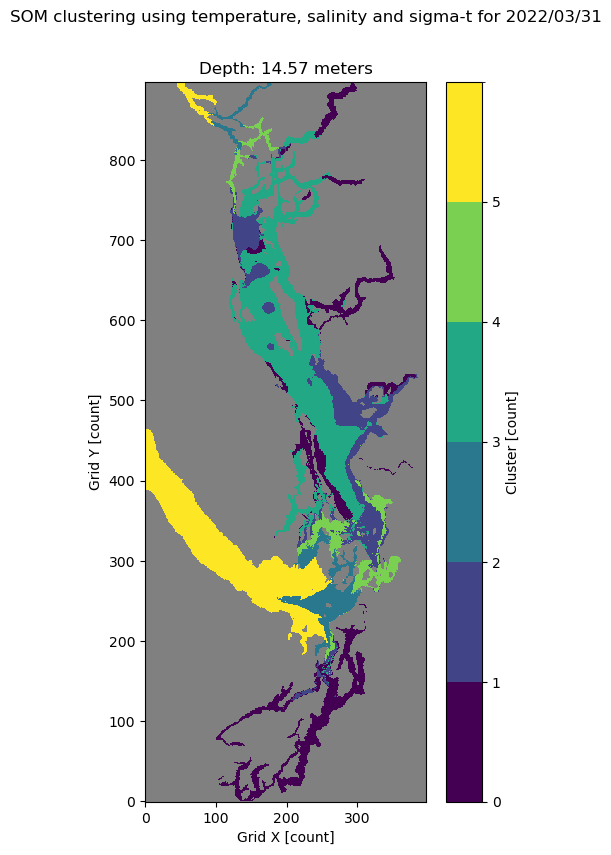

The amount of grid boxes for cluster 0 is 11411 

The minimum temperature for cluster 0 is 8.07 degrees Celsius
The maximum temperature for cluster 0 is 10.53 degrees Celsius
The mean temperature for cluster 0 is 8.73 degrees Celsius 

The minimum salinity for cluster 0 is 28.05 g/kg
The maximum salinity for cluster 0 is 29.6 g/kg
The mean salinity for cluster 0 is 28.91 g/kg 


The amount of grid boxes for cluster 1 is 5175 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.66 degrees Celsius
The mean temperature for cluster 1 is 8.01 degrees Celsius 

The minimum salinity for cluster 1 is 29.39 g/kg
The maximum salinity for cluster 1 is 29.91 g/kg
The mean salinity for cluster 1 is 29.59 g/kg 


The amount of grid boxes for cluster 2 is 16370 

The minimum temperature for cluster 2 is 7.2 degrees Celsius
The maximum temperature for cluster 2 is 8.26 degrees Celsius
The mean temperature for cluster 2 is 7.81 degrees Celsius 

The

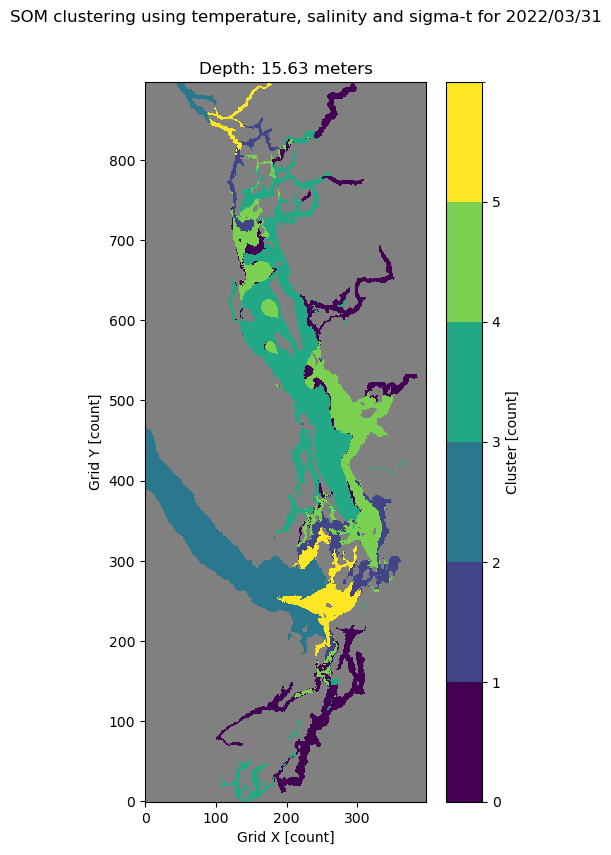

The amount of grid boxes for cluster 0 is 14290 

The minimum temperature for cluster 0 is 8.09 degrees Celsius
The maximum temperature for cluster 0 is 10.49 degrees Celsius
The mean temperature for cluster 0 is 8.66 degrees Celsius 

The minimum salinity for cluster 0 is 28.06 g/kg
The maximum salinity for cluster 0 is 29.64 g/kg
The mean salinity for cluster 0 is 29.06 g/kg 


The amount of grid boxes for cluster 1 is 4057 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.66 degrees Celsius
The mean temperature for cluster 1 is 7.97 degrees Celsius 

The minimum salinity for cluster 1 is 29.51 g/kg
The maximum salinity for cluster 1 is 29.94 g/kg
The mean salinity for cluster 1 is 29.65 g/kg 


The amount of grid boxes for cluster 2 is 16353 

The minimum temperature for cluster 2 is 7.17 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 7.8 degrees Celsius 

Th

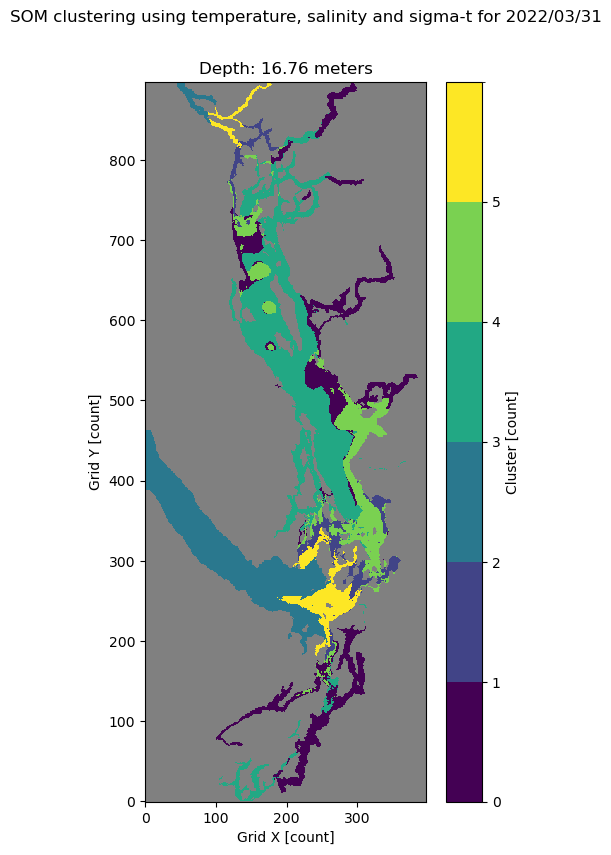

The amount of grid boxes for cluster 0 is 10851 

The minimum temperature for cluster 0 is 6.48 degrees Celsius
The maximum temperature for cluster 0 is 10.42 degrees Celsius
The mean temperature for cluster 0 is 8.82 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.67 g/kg
The mean salinity for cluster 0 is 28.75 g/kg 


The amount of grid boxes for cluster 1 is 6169 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.83 degrees Celsius
The mean temperature for cluster 1 is 8.11 degrees Celsius 

The minimum salinity for cluster 1 is 29.35 g/kg
The maximum salinity for cluster 1 is 29.89 g/kg
The mean salinity for cluster 1 is 29.51 g/kg 


The amount of grid boxes for cluster 2 is 17215 

The minimum temperature for cluster 2 is 7.16 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 7.79 degrees Celsius 

The

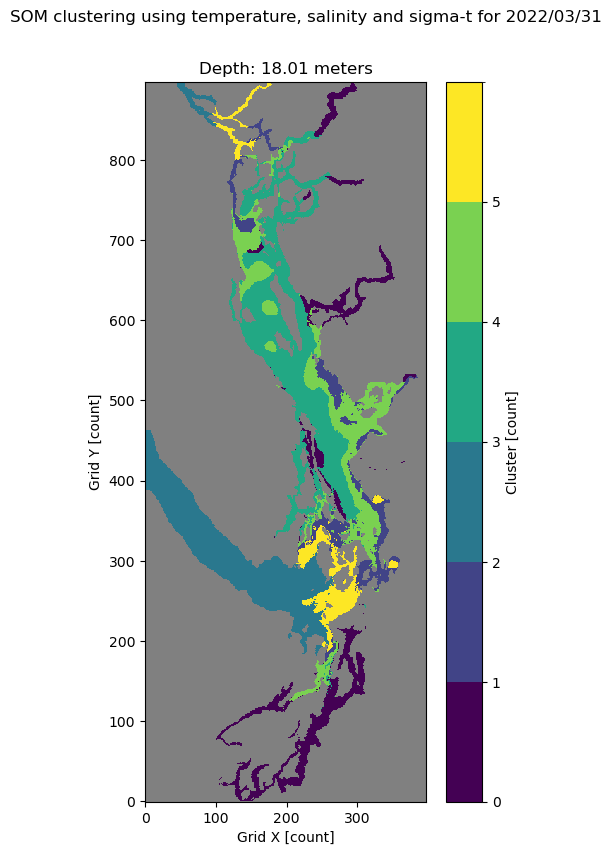

The amount of grid boxes for cluster 0 is 3915 

The minimum temperature for cluster 0 is 7.24 degrees Celsius
The maximum temperature for cluster 0 is 8.14 degrees Celsius
The mean temperature for cluster 0 is 7.86 degrees Celsius 

The minimum salinity for cluster 0 is 29.87 g/kg
The maximum salinity for cluster 0 is 30.31 g/kg
The mean salinity for cluster 0 is 30.07 g/kg 


The amount of grid boxes for cluster 1 is 9349 

The minimum temperature for cluster 1 is 7.92 degrees Celsius
The maximum temperature for cluster 1 is 8.88 degrees Celsius
The mean temperature for cluster 1 is 8.24 degrees Celsius 

The minimum salinity for cluster 1 is 29.26 g/kg
The maximum salinity for cluster 1 is 29.89 g/kg
The mean salinity for cluster 1 is 29.39 g/kg 


The amount of grid boxes for cluster 2 is 10211 

The minimum temperature for cluster 2 is 8.29 degrees Celsius
The maximum temperature for cluster 2 is 10.33 degrees Celsius
The mean temperature for cluster 2 is 8.88 degrees Celsius 

Th

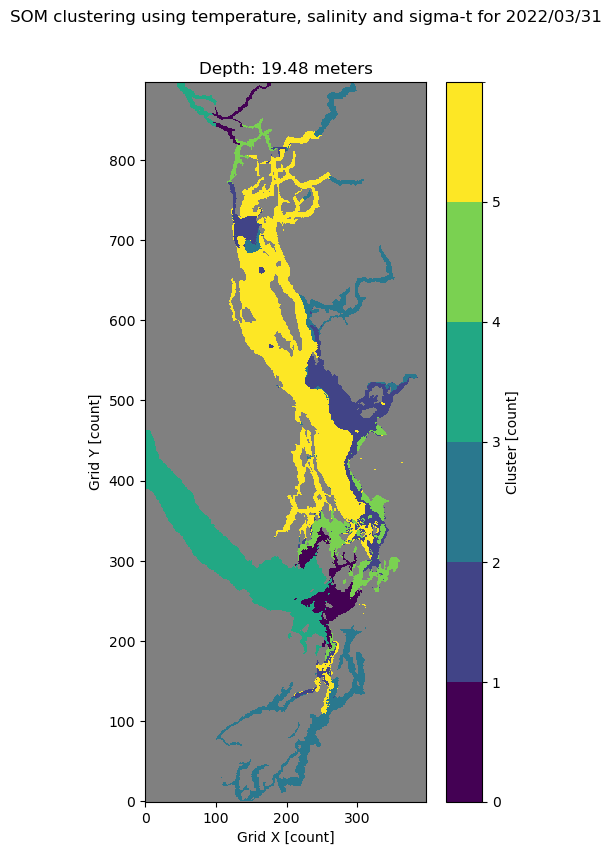

The amount of grid boxes for cluster 0 is 4273 

The minimum temperature for cluster 0 is 7.34 degrees Celsius
The maximum temperature for cluster 0 is 8.14 degrees Celsius
The mean temperature for cluster 0 is 7.85 degrees Celsius 

The minimum salinity for cluster 0 is 29.98 g/kg
The maximum salinity for cluster 0 is 30.57 g/kg
The mean salinity for cluster 0 is 30.28 g/kg 


The amount of grid boxes for cluster 1 is 14998 

The minimum temperature for cluster 1 is 7.79 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 8.41 degrees Celsius 

The minimum salinity for cluster 1 is 29.28 g/kg
The maximum salinity for cluster 1 is 29.9 g/kg
The mean salinity for cluster 1 is 29.46 g/kg 


The amount of grid boxes for cluster 2 is 9905 

The minimum temperature for cluster 2 is 7.96 degrees Celsius
The maximum temperature for cluster 2 is 10.19 degrees Celsius
The mean temperature for cluster 2 is 8.6 degrees Celsius 

The

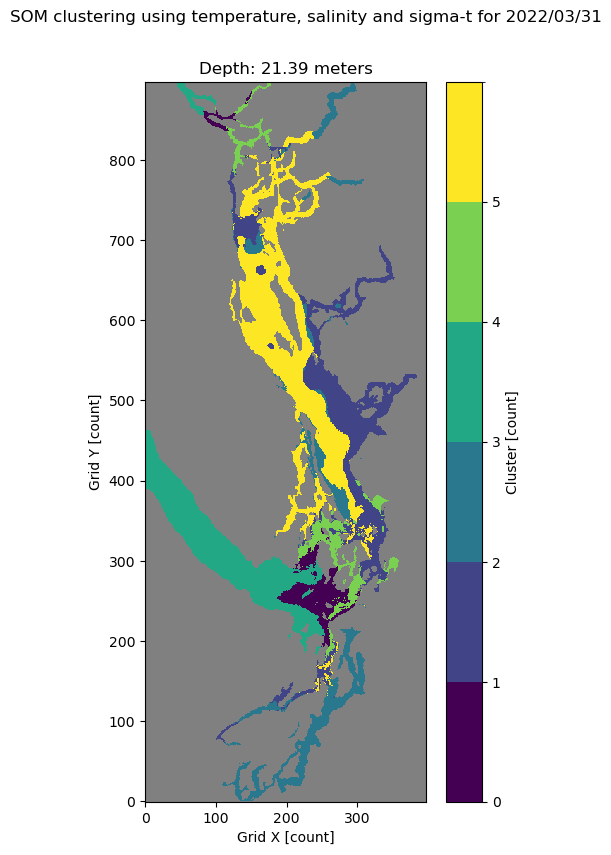

The amount of grid boxes for cluster 0 is 15621 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 8.13 degrees Celsius
The mean temperature for cluster 0 is 7.73 degrees Celsius 

The minimum salinity for cluster 0 is 30.39 g/kg
The maximum salinity for cluster 0 is 32.22 g/kg
The mean salinity for cluster 0 is 31.08 g/kg 


The amount of grid boxes for cluster 1 is 6593 

The minimum temperature for cluster 1 is 7.6 degrees Celsius
The maximum temperature for cluster 1 is 8.31 degrees Celsius
The mean temperature for cluster 1 is 7.94 degrees Celsius 

The minimum salinity for cluster 1 is 29.39 g/kg
The maximum salinity for cluster 1 is 30.0 g/kg
The mean salinity for cluster 1 is 29.65 g/kg 


The amount of grid boxes for cluster 2 is 19990 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.81 degrees Celsius
The mean temperature for cluster 2 is 8.03 degrees Celsius 

The 

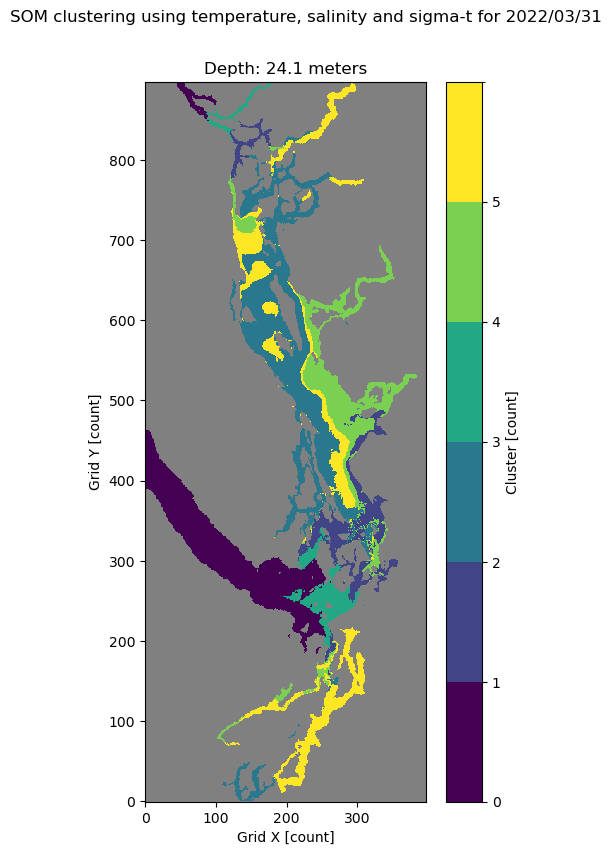

The amount of grid boxes for cluster 0 is 3723 

The minimum temperature for cluster 0 is 7.29 degrees Celsius
The maximum temperature for cluster 0 is 8.1 degrees Celsius
The mean temperature for cluster 0 is 7.82 degrees Celsius 

The minimum salinity for cluster 0 is 29.81 g/kg
The maximum salinity for cluster 0 is 30.6 g/kg
The mean salinity for cluster 0 is 30.22 g/kg 


The amount of grid boxes for cluster 1 is 9762 

The minimum temperature for cluster 1 is 7.67 degrees Celsius
The maximum temperature for cluster 1 is 8.7 degrees Celsius
The mean temperature for cluster 1 is 8.04 degrees Celsius 

The minimum salinity for cluster 1 is 28.74 g/kg
The maximum salinity for cluster 1 is 29.8 g/kg
The mean salinity for cluster 1 is 29.56 g/kg 


The amount of grid boxes for cluster 2 is 23860 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.8 degrees Celsius
The mean temperature for cluster 2 is 8.13 degrees Celsius 

The mini

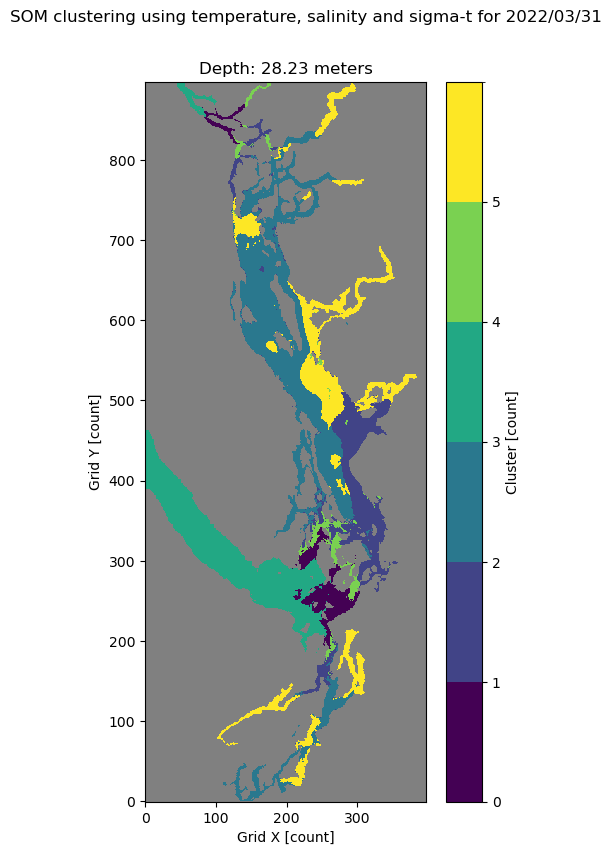

The amount of grid boxes for cluster 0 is 4348 

The minimum temperature for cluster 0 is 7.23 degrees Celsius
The maximum temperature for cluster 0 is 8.03 degrees Celsius
The mean temperature for cluster 0 is 7.76 degrees Celsius 

The minimum salinity for cluster 0 is 29.93 g/kg
The maximum salinity for cluster 0 is 30.91 g/kg
The mean salinity for cluster 0 is 30.64 g/kg 


The amount of grid boxes for cluster 1 is 10159 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 8.88 degrees Celsius
The mean temperature for cluster 1 is 8.0 degrees Celsius 

The minimum salinity for cluster 1 is 29.2 g/kg
The maximum salinity for cluster 1 is 29.99 g/kg
The mean salinity for cluster 1 is 29.69 g/kg 


The amount of grid boxes for cluster 2 is 25382 

The minimum temperature for cluster 2 is 7.63 degrees Celsius
The maximum temperature for cluster 2 is 8.78 degrees Celsius
The mean temperature for cluster 2 is 8.22 degrees Celsius 

The 

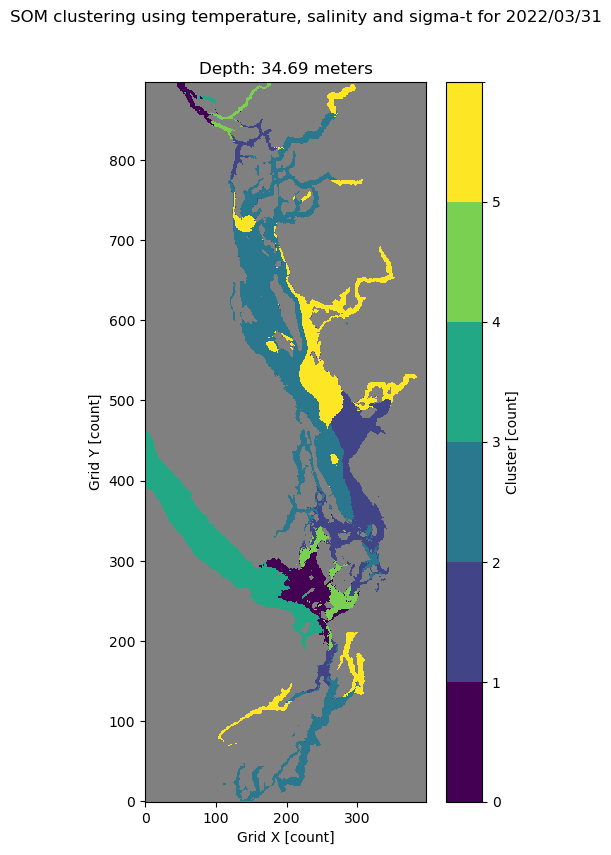

The amount of grid boxes for cluster 0 is 11330 

The minimum temperature for cluster 0 is 7.14 degrees Celsius
The maximum temperature for cluster 0 is 7.78 degrees Celsius
The mean temperature for cluster 0 is 7.56 degrees Celsius 

The minimum salinity for cluster 0 is 30.83 g/kg
The maximum salinity for cluster 0 is 32.93 g/kg
The mean salinity for cluster 0 is 31.72 g/kg 


The amount of grid boxes for cluster 1 is 7882 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 9.02 degrees Celsius
The mean temperature for cluster 1 is 7.91 degrees Celsius 

The minimum salinity for cluster 1 is 29.63 g/kg
The maximum salinity for cluster 1 is 30.55 g/kg
The mean salinity for cluster 1 is 29.97 g/kg 


The amount of grid boxes for cluster 2 is 35996 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 10.31 degrees Celsius
The mean temperature for cluster 2 is 8.46 degrees Celsius 

T

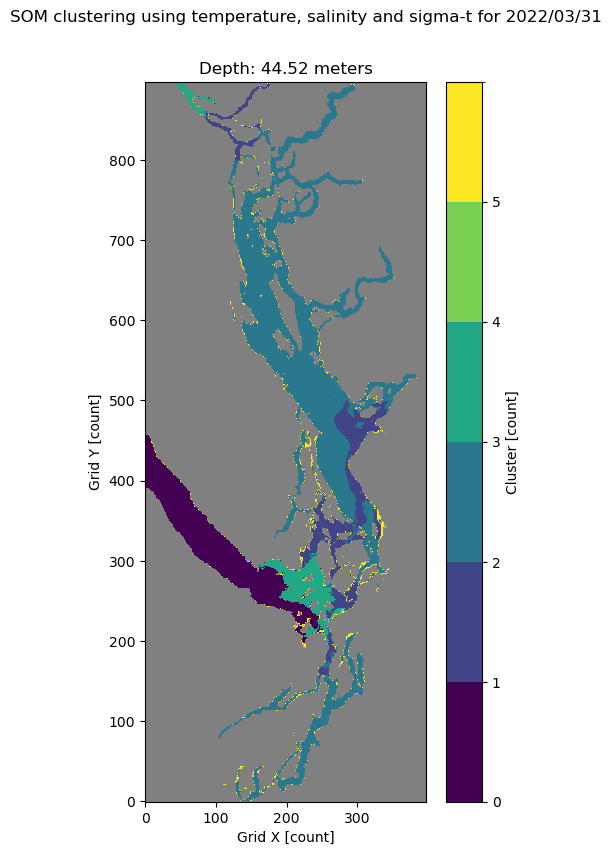

The amount of grid boxes for cluster 0 is 23495 

The minimum temperature for cluster 0 is 8.11 degrees Celsius
The maximum temperature for cluster 0 is 10.39 degrees Celsius
The mean temperature for cluster 0 is 8.69 degrees Celsius 

The minimum salinity for cluster 0 is 27.49 g/kg
The maximum salinity for cluster 0 is 30.47 g/kg
The mean salinity for cluster 0 is 29.82 g/kg 


The amount of grid boxes for cluster 1 is 485 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 10.29 degrees Celsius
The mean temperature for cluster 1 is 8.29 degrees Celsius 

The minimum salinity for cluster 1 is 27.46 g/kg
The maximum salinity for cluster 1 is 30.67 g/kg
The mean salinity for cluster 1 is 29.69 g/kg 


The amount of grid boxes for cluster 2 is 3749 

The minimum temperature for cluster 2 is 7.15 degrees Celsius
The maximum temperature for cluster 2 is 10.35 degrees Celsius
The mean temperature for cluster 2 is 8.06 degrees Celsius 

T

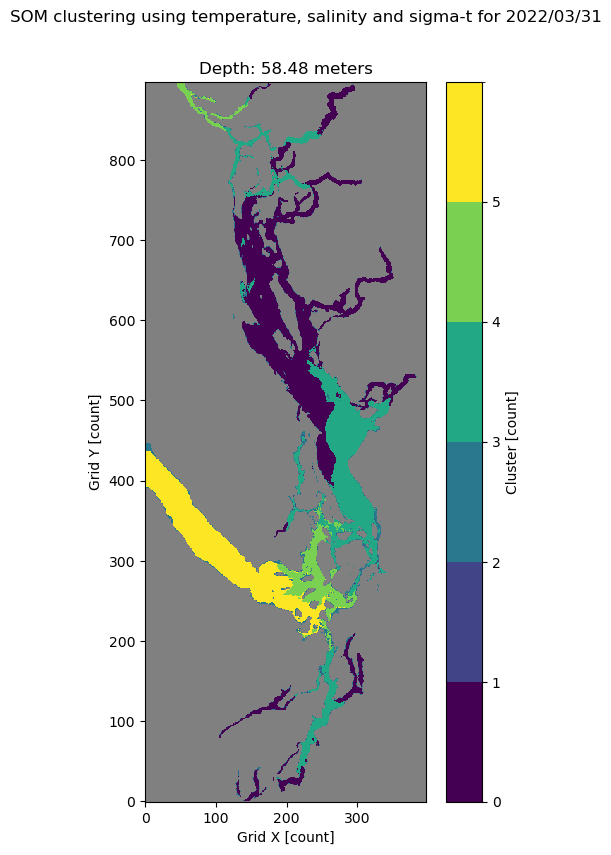

The amount of grid boxes for cluster 0 is 3886 

The minimum temperature for cluster 0 is 7.2 degrees Celsius
The maximum temperature for cluster 0 is 10.45 degrees Celsius
The mean temperature for cluster 0 is 8.06 degrees Celsius 

The minimum salinity for cluster 0 is 27.51 g/kg
The maximum salinity for cluster 0 is 33.3 g/kg
The mean salinity for cluster 0 is 30.47 g/kg 


The amount of grid boxes for cluster 1 is 536 

The minimum temperature for cluster 1 is 7.26 degrees Celsius
The maximum temperature for cluster 1 is 10.29 degrees Celsius
The mean temperature for cluster 1 is 8.36 degrees Celsius 

The minimum salinity for cluster 1 is 27.54 g/kg
The maximum salinity for cluster 1 is 31.14 g/kg
The mean salinity for cluster 1 is 29.92 g/kg 


The amount of grid boxes for cluster 2 is 25146 

The minimum temperature for cluster 2 is 7.65 degrees Celsius
The maximum temperature for cluster 2 is 10.45 degrees Celsius
The mean temperature for cluster 2 is 8.66 degrees Celsius 

The

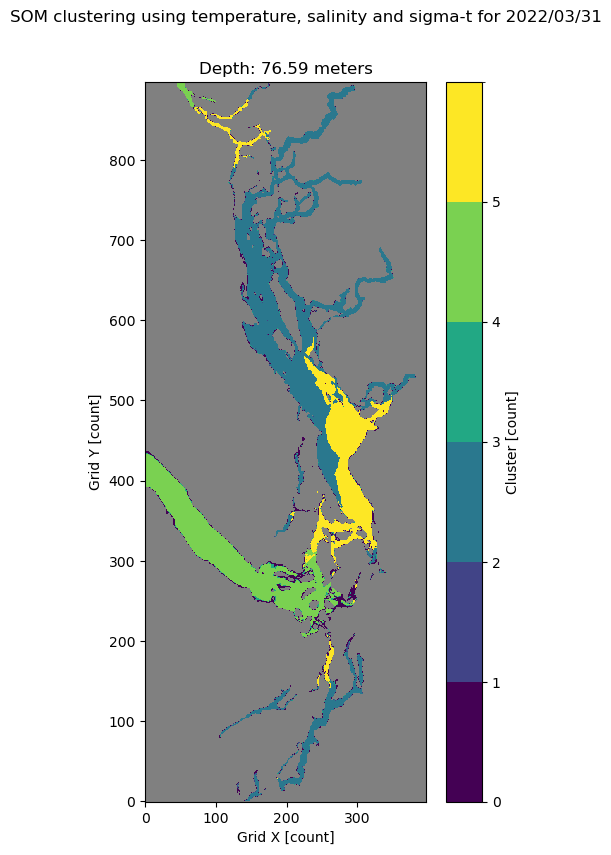

The amount of grid boxes for cluster 0 is 9395 

The minimum temperature for cluster 0 is 7.07 degrees Celsius
The maximum temperature for cluster 0 is 7.64 degrees Celsius
The mean temperature for cluster 0 is 7.26 degrees Celsius 

The minimum salinity for cluster 0 is 31.15 g/kg
The maximum salinity for cluster 0 is 33.55 g/kg
The mean salinity for cluster 0 is 32.94 g/kg 


The amount of grid boxes for cluster 1 is 218 

The minimum temperature for cluster 1 is 7.13 degrees Celsius
The maximum temperature for cluster 1 is 8.69 degrees Celsius
The mean temperature for cluster 1 is 7.44 degrees Celsius 

The minimum salinity for cluster 1 is 30.01 g/kg
The maximum salinity for cluster 1 is 33.42 g/kg
The mean salinity for cluster 1 is 32.03 g/kg 


The amount of grid boxes for cluster 2 is 4438 

The minimum temperature for cluster 2 is 7.08 degrees Celsius
The maximum temperature for cluster 2 is 10.48 degrees Celsius
The mean temperature for cluster 2 is 8.05 degrees Celsius 

The 

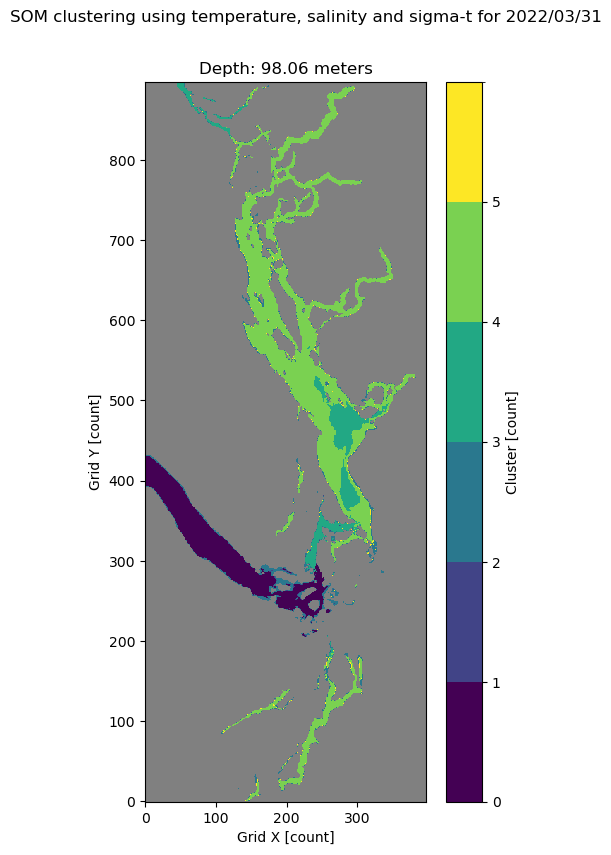

The amount of grid boxes for cluster 0 is 839 

The minimum temperature for cluster 0 is 6.98 degrees Celsius
The maximum temperature for cluster 0 is 10.57 degrees Celsius
The mean temperature for cluster 0 is 7.81 degrees Celsius 

The minimum salinity for cluster 0 is 29.12 g/kg
The maximum salinity for cluster 0 is 33.6 g/kg
The mean salinity for cluster 0 is 31.54 g/kg 


The amount of grid boxes for cluster 1 is 7316 

The minimum temperature for cluster 1 is 6.94 degrees Celsius
The maximum temperature for cluster 1 is 7.6 degrees Celsius
The mean temperature for cluster 1 is 7.16 degrees Celsius 

The minimum salinity for cluster 1 is 31.44 g/kg
The maximum salinity for cluster 1 is 33.68 g/kg
The mean salinity for cluster 1 is 33.25 g/kg 


The amount of grid boxes for cluster 2 is 1110 

The minimum temperature for cluster 2 is 7.29 degrees Celsius
The maximum temperature for cluster 2 is 7.89 degrees Celsius
The mean temperature for cluster 2 is 7.66 degrees Celsius 

The mi

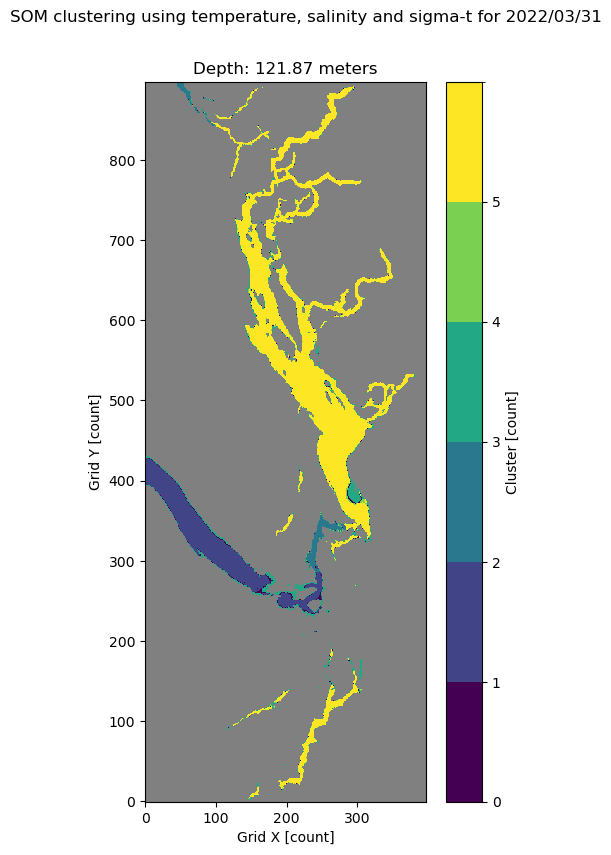

The amount of grid boxes for cluster 0 is 22679 

The minimum temperature for cluster 0 is 7.4 degrees Celsius
The maximum temperature for cluster 0 is 10.78 degrees Celsius
The mean temperature for cluster 0 is 8.56 degrees Celsius 

The minimum salinity for cluster 0 is 28.21 g/kg
The maximum salinity for cluster 0 is 30.87 g/kg
The mean salinity for cluster 0 is 30.45 g/kg 


The amount of grid boxes for cluster 1 is 658 

The minimum temperature for cluster 1 is 7.3 degrees Celsius
The maximum temperature for cluster 1 is 10.62 degrees Celsius
The mean temperature for cluster 1 is 8.43 degrees Celsius 

The minimum salinity for cluster 1 is 28.2 g/kg
The maximum salinity for cluster 1 is 32.23 g/kg
The mean salinity for cluster 1 is 30.4 g/kg 


The amount of grid boxes for cluster 2 is 3636 

The minimum temperature for cluster 2 is 6.94 degrees Celsius
The maximum temperature for cluster 2 is 10.76 degrees Celsius
The mean temperature for cluster 2 is 8.05 degrees Celsius 

The m

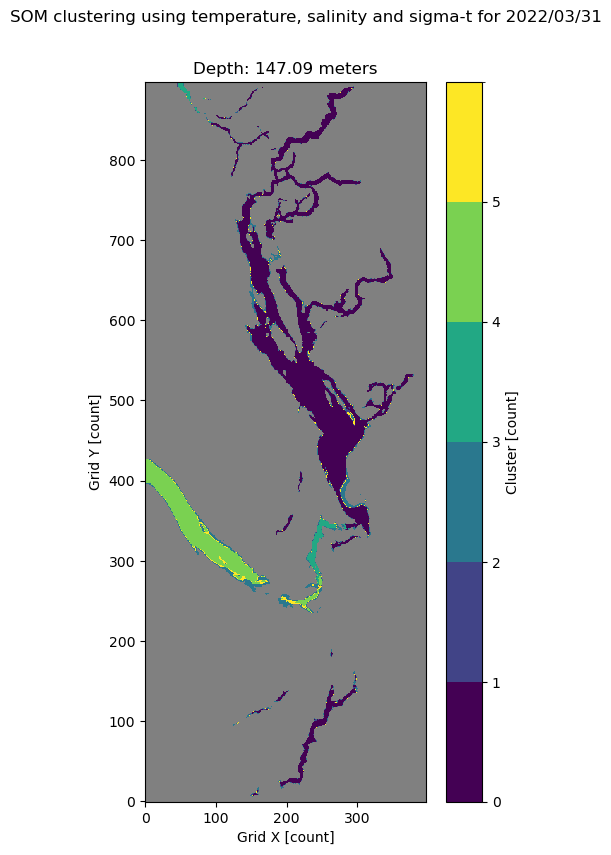

The amount of grid boxes for cluster 0 is 18726 

The minimum temperature for cluster 0 is 7.38 degrees Celsius
The maximum temperature for cluster 0 is 10.79 degrees Celsius
The mean temperature for cluster 0 is 8.69 degrees Celsius 

The minimum salinity for cluster 0 is 29.12 g/kg
The maximum salinity for cluster 0 is 31.0 g/kg
The mean salinity for cluster 0 is 30.58 g/kg 


The amount of grid boxes for cluster 1 is 671 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 10.8 degrees Celsius
The mean temperature for cluster 1 is 8.6 degrees Celsius 

The minimum salinity for cluster 1 is 29.16 g/kg
The maximum salinity for cluster 1 is 31.34 g/kg
The mean salinity for cluster 1 is 30.49 g/kg 


The amount of grid boxes for cluster 2 is 2701 

The minimum temperature for cluster 2 is 6.85 degrees Celsius
The maximum temperature for cluster 2 is 10.8 degrees Celsius
The mean temperature for cluster 2 is 7.99 degrees Celsius 

The m

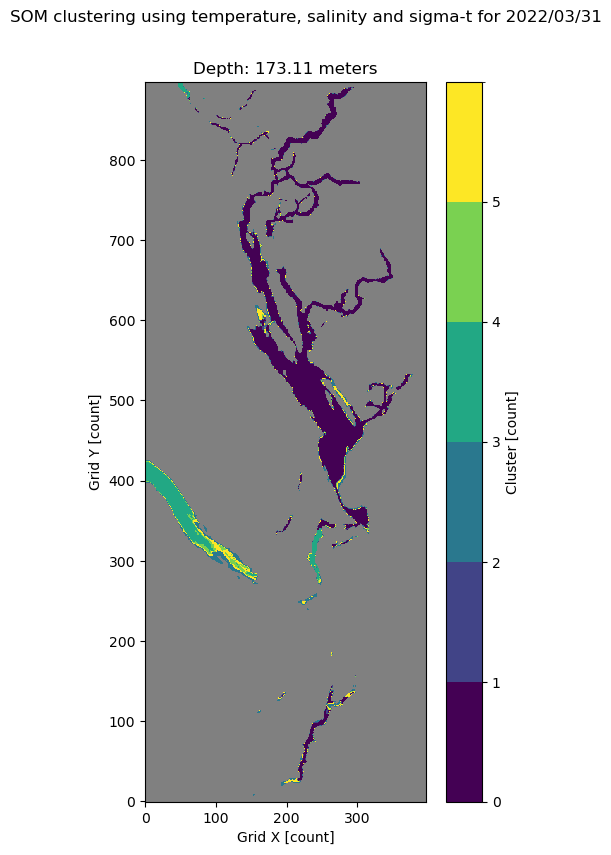

The amount of grid boxes for cluster 0 is 1002 

The minimum temperature for cluster 0 is 6.7 degrees Celsius
The maximum temperature for cluster 0 is 9.81 degrees Celsius
The mean temperature for cluster 0 is 8.08 degrees Celsius 

The minimum salinity for cluster 0 is 29.18 g/kg
The maximum salinity for cluster 0 is 33.85 g/kg
The mean salinity for cluster 0 is 31.41 g/kg 


The amount of grid boxes for cluster 1 is 404 

The minimum temperature for cluster 1 is 6.66 degrees Celsius
The maximum temperature for cluster 1 is 9.87 degrees Celsius
The mean temperature for cluster 1 is 8.39 degrees Celsius 

The minimum salinity for cluster 1 is 29.18 g/kg
The maximum salinity for cluster 1 is 33.86 g/kg
The mean salinity for cluster 1 is 30.98 g/kg 


The amount of grid boxes for cluster 2 is 14890 

The minimum temperature for cluster 2 is 7.44 degrees Celsius
The maximum temperature for cluster 2 is 9.92 degrees Celsius
The mean temperature for cluster 2 is 8.86 degrees Celsius 

The m

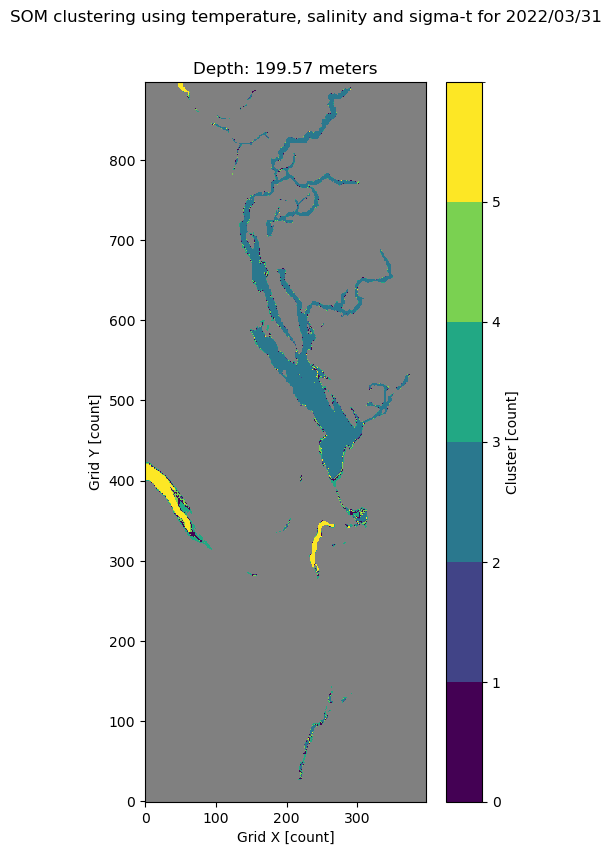

The amount of grid boxes for cluster 0 is 9405 

The minimum temperature for cluster 0 is 8.55 degrees Celsius
The maximum temperature for cluster 0 is 9.68 degrees Celsius
The mean temperature for cluster 0 is 9.19 degrees Celsius 

The minimum salinity for cluster 0 is 30.16 g/kg
The maximum salinity for cluster 0 is 31.04 g/kg
The mean salinity for cluster 0 is 30.82 g/kg 


The amount of grid boxes for cluster 1 is 158 

The minimum temperature for cluster 1 is 6.92 degrees Celsius
The maximum temperature for cluster 1 is 9.4 degrees Celsius
The mean temperature for cluster 1 is 8.85 degrees Celsius 

The minimum salinity for cluster 1 is 29.81 g/kg
The maximum salinity for cluster 1 is 33.75 g/kg
The mean salinity for cluster 1 is 30.79 g/kg 


The amount of grid boxes for cluster 2 is 719 

The minimum temperature for cluster 2 is 6.51 degrees Celsius
The maximum temperature for cluster 2 is 9.4 degrees Celsius
The mean temperature for cluster 2 is 8.33 degrees Celsius 

The mini

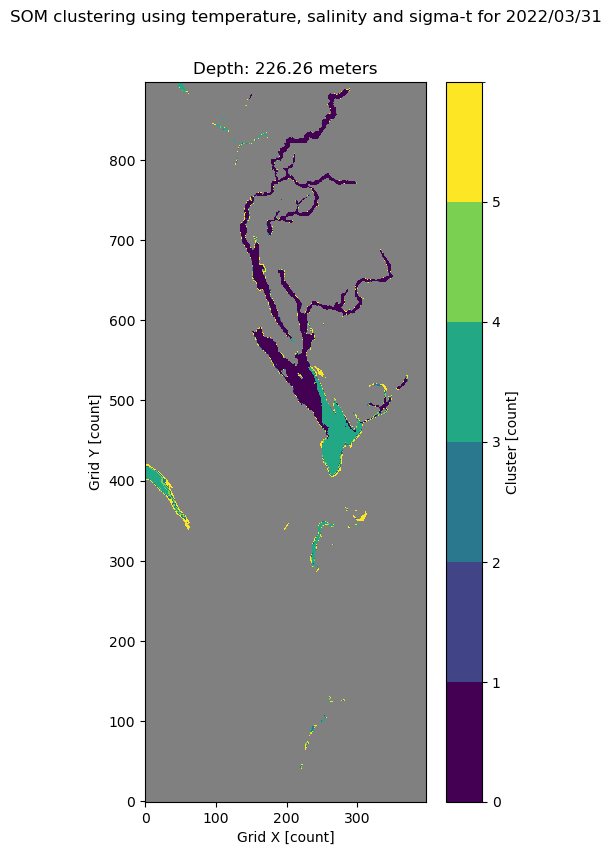

The amount of grid boxes for cluster 0 is 2079 

The minimum temperature for cluster 0 is 6.43 degrees Celsius
The maximum temperature for cluster 0 is 9.02 degrees Celsius
The mean temperature for cluster 0 is 8.41 degrees Celsius 

The minimum salinity for cluster 0 is 29.83 g/kg
The maximum salinity for cluster 0 is 33.96 g/kg
The mean salinity for cluster 0 is 31.02 g/kg 


The amount of grid boxes for cluster 1 is 402 

The minimum temperature for cluster 1 is 6.43 degrees Celsius
The maximum temperature for cluster 1 is 9.41 degrees Celsius
The mean temperature for cluster 1 is 8.73 degrees Celsius 

The minimum salinity for cluster 1 is 29.83 g/kg
The maximum salinity for cluster 1 is 33.96 g/kg
The mean salinity for cluster 1 is 31.13 g/kg 


The amount of grid boxes for cluster 2 is 1245 

The minimum temperature for cluster 2 is 6.43 degrees Celsius
The maximum temperature for cluster 2 is 9.69 degrees Celsius
The mean temperature for cluster 2 is 8.54 degrees Celsius 

The m

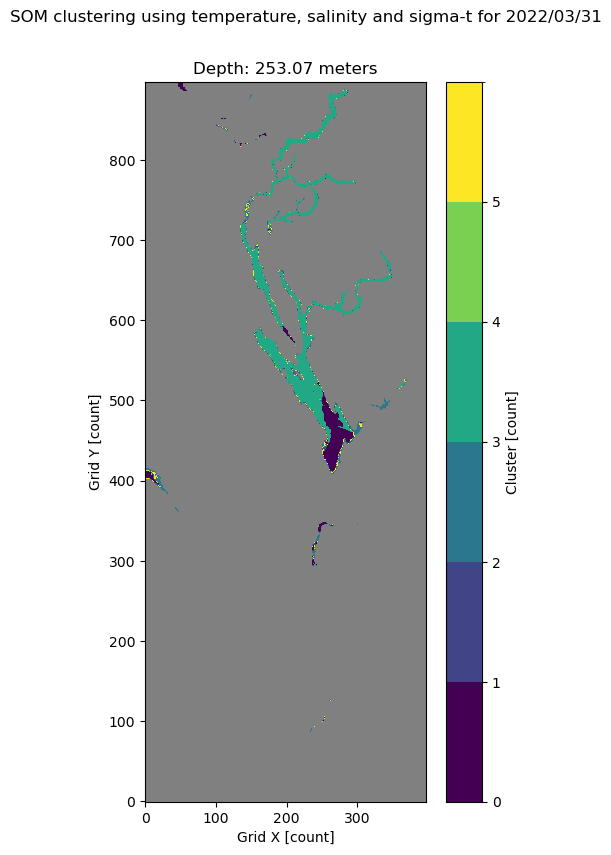

The amount of grid boxes for cluster 0 is 360 

The minimum temperature for cluster 0 is 7.45 degrees Celsius
The maximum temperature for cluster 0 is 9.41 degrees Celsius
The mean temperature for cluster 0 is 9.04 degrees Celsius 

The minimum salinity for cluster 0 is 29.83 g/kg
The maximum salinity for cluster 0 is 31.38 g/kg
The mean salinity for cluster 0 is 30.9 g/kg 


The amount of grid boxes for cluster 1 is 99 

The minimum temperature for cluster 1 is 7.61 degrees Celsius
The maximum temperature for cluster 1 is 9.41 degrees Celsius
The mean temperature for cluster 1 is 9.07 degrees Celsius 

The minimum salinity for cluster 1 is 29.96 g/kg
The maximum salinity for cluster 1 is 31.22 g/kg
The mean salinity for cluster 1 is 30.94 g/kg 


The amount of grid boxes for cluster 2 is 8616 

The minimum temperature for cluster 2 is 7.53 degrees Celsius
The maximum temperature for cluster 2 is 9.42 degrees Celsius
The mean temperature for cluster 2 is 9.16 degrees Celsius 

The mini

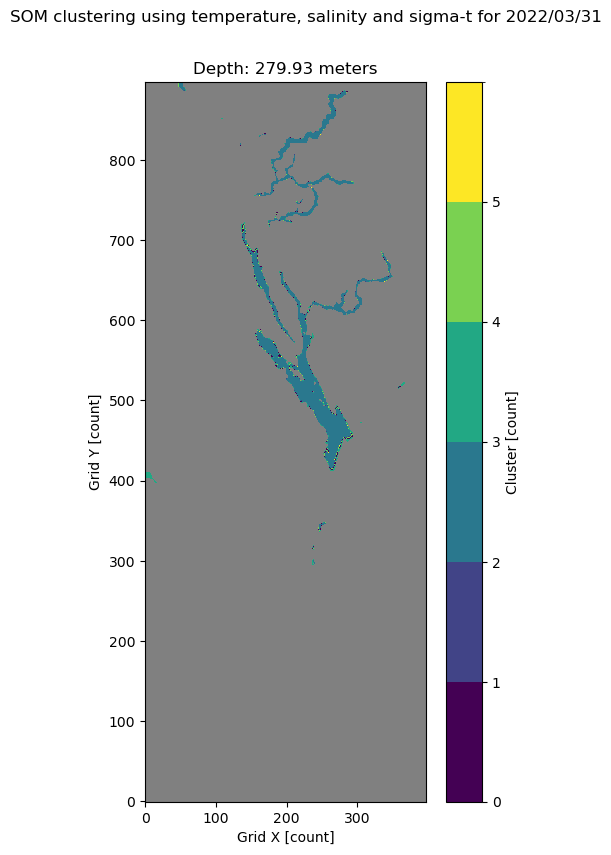

The amount of grid boxes for cluster 0 is 6808 

The minimum temperature for cluster 0 is 7.6 degrees Celsius
The maximum temperature for cluster 0 is 9.44 degrees Celsius
The mean temperature for cluster 0 is 9.23 degrees Celsius 

The minimum salinity for cluster 0 is 30.56 g/kg
The maximum salinity for cluster 0 is 31.23 g/kg
The mean salinity for cluster 0 is 30.96 g/kg 


The amount of grid boxes for cluster 1 is 162 

The minimum temperature for cluster 1 is 7.53 degrees Celsius
The maximum temperature for cluster 1 is 9.42 degrees Celsius
The mean temperature for cluster 1 is 9.15 degrees Celsius 

The minimum salinity for cluster 1 is 29.95 g/kg
The maximum salinity for cluster 1 is 31.58 g/kg
The mean salinity for cluster 1 is 30.99 g/kg 


The amount of grid boxes for cluster 2 is 392 

The minimum temperature for cluster 2 is 7.59 degrees Celsius
The maximum temperature for cluster 2 is 9.42 degrees Celsius
The mean temperature for cluster 2 is 9.15 degrees Celsius 

The min

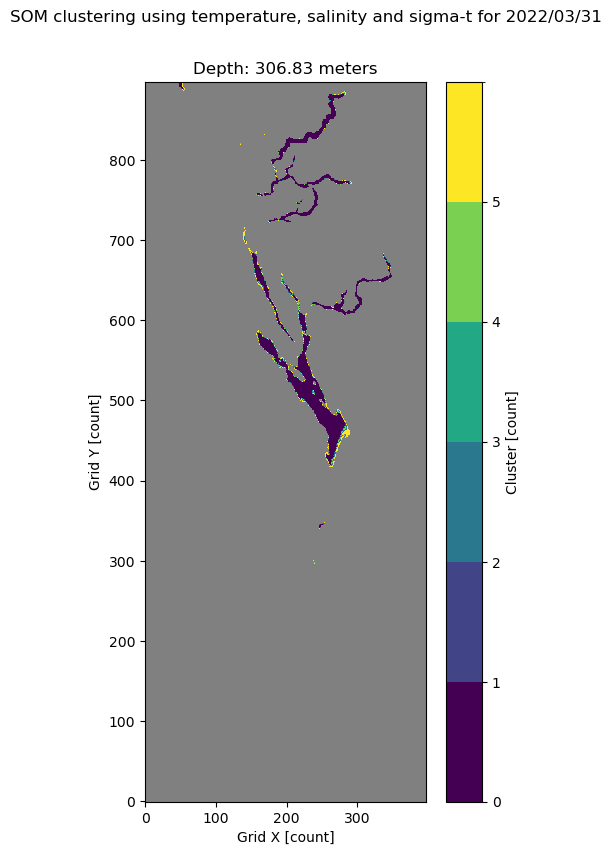

The amount of grid boxes for cluster 0 is 64 

The minimum temperature for cluster 0 is 8.76 degrees Celsius
The maximum temperature for cluster 0 is 9.44 degrees Celsius
The mean temperature for cluster 0 is 9.31 degrees Celsius 

The minimum salinity for cluster 0 is 30.7 g/kg
The maximum salinity for cluster 0 is 31.16 g/kg
The mean salinity for cluster 0 is 31.02 g/kg 


The amount of grid boxes for cluster 1 is 330 

The minimum temperature for cluster 1 is 7.6 degrees Celsius
The maximum temperature for cluster 1 is 9.44 degrees Celsius
The mean temperature for cluster 1 is 9.25 degrees Celsius 

The minimum salinity for cluster 1 is 30.57 g/kg
The maximum salinity for cluster 1 is 31.23 g/kg
The mean salinity for cluster 1 is 31.02 g/kg 


The amount of grid boxes for cluster 2 is 777 

The minimum temperature for cluster 2 is 7.6 degrees Celsius
The maximum temperature for cluster 2 is 9.43 degrees Celsius
The mean temperature for cluster 2 is 9.15 degrees Celsius 

The minimum

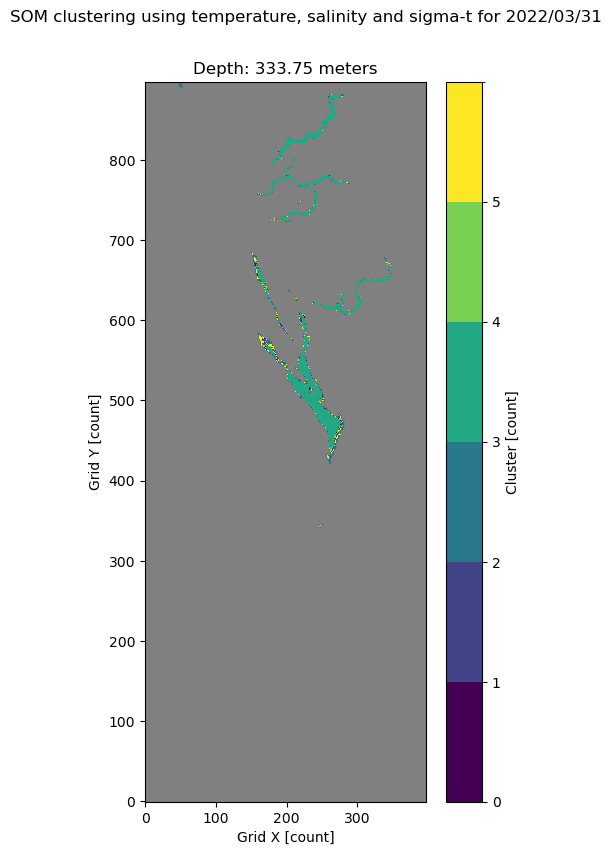

The amount of grid boxes for cluster 0 is 194 

The minimum temperature for cluster 0 is 8.94 degrees Celsius
The maximum temperature for cluster 0 is 9.45 degrees Celsius
The mean temperature for cluster 0 is 9.33 degrees Celsius 

The minimum salinity for cluster 0 is 30.68 g/kg
The maximum salinity for cluster 0 is 31.17 g/kg
The mean salinity for cluster 0 is 31.06 g/kg 


The amount of grid boxes for cluster 1 is 133 

The minimum temperature for cluster 1 is 8.93 degrees Celsius
The maximum temperature for cluster 1 is 9.45 degrees Celsius
The mean temperature for cluster 1 is 9.28 degrees Celsius 

The minimum salinity for cluster 1 is 30.68 g/kg
The maximum salinity for cluster 1 is 31.17 g/kg
The mean salinity for cluster 1 is 31.01 g/kg 


The amount of grid boxes for cluster 2 is 3581 

The minimum temperature for cluster 2 is 8.93 degrees Celsius
The maximum temperature for cluster 2 is 9.45 degrees Celsius
The mean temperature for cluster 2 is 9.24 degrees Celsius 

The mi

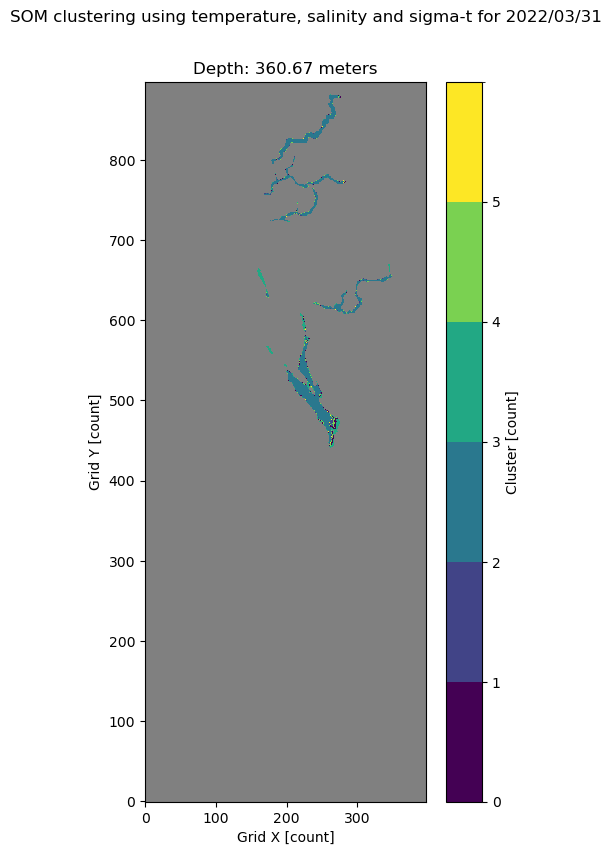

The amount of grid boxes for cluster 0 is 73 

The minimum temperature for cluster 0 is 8.95 degrees Celsius
The maximum temperature for cluster 0 is 9.44 degrees Celsius
The mean temperature for cluster 0 is 9.19 degrees Celsius 

The minimum salinity for cluster 0 is 30.68 g/kg
The maximum salinity for cluster 0 is 31.18 g/kg
The mean salinity for cluster 0 is 30.92 g/kg 


The amount of grid boxes for cluster 1 is 178 

The minimum temperature for cluster 1 is 8.95 degrees Celsius
The maximum temperature for cluster 1 is 9.45 degrees Celsius
The mean temperature for cluster 1 is 9.38 degrees Celsius 

The minimum salinity for cluster 1 is 30.68 g/kg
The maximum salinity for cluster 1 is 31.18 g/kg
The mean salinity for cluster 1 is 31.1 g/kg 


The amount of grid boxes for cluster 2 is 437 

The minimum temperature for cluster 2 is 8.95 degrees Celsius
The maximum temperature for cluster 2 is 9.45 degrees Celsius
The mean temperature for cluster 2 is 9.38 degrees Celsius 

The minim

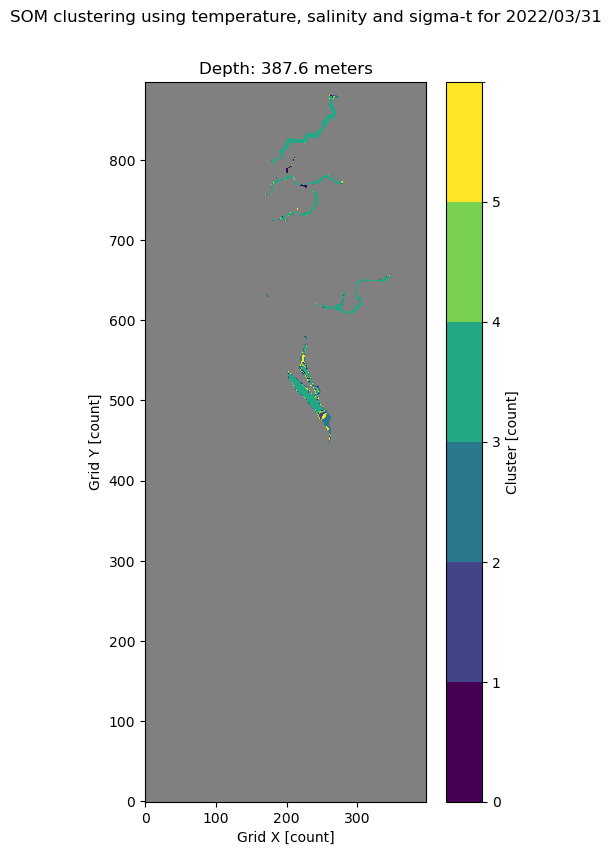

The amount of grid boxes for cluster 0 is 406 

The minimum temperature for cluster 0 is 8.92 degrees Celsius
The maximum temperature for cluster 0 is 9.45 degrees Celsius
The mean temperature for cluster 0 is 9.4 degrees Celsius 

The minimum salinity for cluster 0 is 30.68 g/kg
The maximum salinity for cluster 0 is 31.18 g/kg
The mean salinity for cluster 0 is 31.13 g/kg 


The amount of grid boxes for cluster 1 is 66 

The minimum temperature for cluster 1 is 8.92 degrees Celsius
The maximum temperature for cluster 1 is 9.44 degrees Celsius
The mean temperature for cluster 1 is 9.27 degrees Celsius 

The minimum salinity for cluster 1 is 30.68 g/kg
The maximum salinity for cluster 1 is 31.18 g/kg
The mean salinity for cluster 1 is 31.0 g/kg 


The amount of grid boxes for cluster 2 is 10 

The minimum temperature for cluster 2 is 9.03 degrees Celsius
The maximum temperature for cluster 2 is 9.43 degrees Celsius
The mean temperature for cluster 2 is 9.19 degrees Celsius 

The minimum

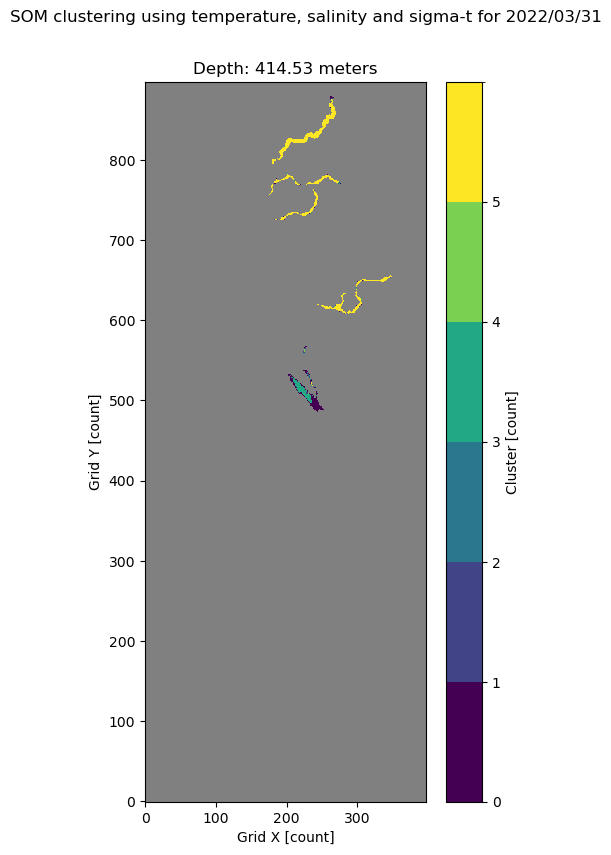

IndexError: index 0 is out of bounds for axis 0 with size 0

In [21]:
ds, temp, saline, sigma, cell, date, mask = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sigma, cell = masking(depth, temp, saline, sigma, cell, mask)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline, sigma, cell)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
